In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import pickle
import random
import os
import gams_magic

# Read Road file

In [2]:
#read link data
road_file_path = os.path.join('..','road_file.csv')
road_file = pd.read_csv(road_file_path,names=["RDWY_LINK_ID","REF_SITE_FROM_ID","REF_SITE_TO_ID"])

In [3]:
road_file

,RDWY_LINK_ID,REF_SITE_FROM_ID,REF_SITE_TO_ID
0,4818580,1661200,1660820
1,4819008,1661678,1661705
2,4819009,1661704,1661705
3,4819014,1661723,1661697
4,4819015,1661705,1661723
...,...,...,...
3127,5571520,1663210,1663276
3128,5571521,1661558,1661551
3129,5571522,1661551,1661558
3130,5571523,2016715,2005025


# read shape file

In [4]:

#shape_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Middleton_CrossPlains_OVLY.shp")
shape_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Middleton_Road_New.shp")
shape = shapefile.Reader(shape_path)
# #first feature of the shapefile
#feature = shape.shapeRecords()[0]
#first = feature.shape.__geo_interface__  
# print first # (GeoJSON format)
# # {'type': 'LineString', 'coordinates': ((0.0, 0.0), (25.0, 10.0), (50.0, 50.0))}

In [5]:
print(shape)

shapefile Reader
    3797 shapes (type 'POLYLINE')


In [6]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()

all_roadId = list(road_file['RDWY_LINK_ID'])
for sp in shape.shapeRecords():
    road_id = sp.record[43]
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    plt.plot(x,y,'g')
    
plt.show()

ShapefileException: Shapefile Reader requires a shapefile or file-like object. (no dbf file found)

<Figure size 1440x720 with 0 Axes>

## Read Crash File

In [9]:
crash_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Crash_data_combined_2017_2020.shp")
crash = shapefile.Reader(crash_path)

# Temp : chosen road

In [10]:
# load reference point coordinate
reference_coordinate = None
reference_path = os.path.join("..","reference_coordinate")

with open(reference_path, 'rb') as f:
    reference_coordinate = pickle.load(f)


In [11]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()

#all_roadId = list(road_file['RDWY_LINK_ID'])
for sp in shape.shapeRecords():
    road_id = sp.record[43]
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    if road_id == 5253202:
        plt.plot(x,y,'r')
    elif road_id == 5253200:
        plt.plot(x,y,'b')
    else:
        plt.plot(x,y,'g')
    
'''
for i in reference_coordinate:
    x = reference_coordinate[i][0]
    y = reference_coordinate[i][1]
    #plt.plot(x,y,'ro')
    
for sp in crash.shapeRecords():
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    if x[0] >200000 and y[0] >400000:
        plt.plot(x,y,'mo')
'''
plt.show()

ShapefileException: Shapefile Reader requires a shapefile or file-like object. (no dbf file found)

<Figure size 1440x720 with 0 Axes>

In [98]:
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

In [99]:
%%gams
$title shortest path try

option limcol = 0, limrow = 0, solprint = off;
set
    nodes
    roadID
;

alias (nodes,i,j);
$gdxin ../link_file.gdx
$loadm nodes=dim1 nodes=dim2
parameter distance(nodes,nodes) distance of a road;
$load  distance=link
$gdxin

$gdxin ../road_file.gdx
set road(roadID<,nodes,nodes);
$load  road=road
$gdxin

$gdxin ../crash_file.gdx
parameter  crash(nodes,nodes) number of crashes on a road;
$load  crash=crash
$gdxin


set arc(nodes,nodes);

arc(i,j) = no;
arc(i,j)$(distance(i,j) > 0.5) = yes;

parameter
    supply(nodes)
;

scalar origin,destination;
execseed = 1 + gmillisec(jnow);
origin = uniformint(1,card(nodes));
destination = uniformint(1,card(nodes));

supply(nodes)$(ord(nodes) = origin) = 1;

supply(nodes)$(ord(nodes) = destination) = -1;


free variable
    total_dist
;

integer variable
    flow(i,j)
;

flow.lo(i,j) = 0

equation
    balance(nodes)
    objective_shortestPath
    objective_safestPath
;


balance(i)..
    sum(arc(i,j), flow(i,j)) - sum(arc(j,i), flow(j,i)) =e= supply(i);
    
objective_shortestPath..
    total_dist =e= sum(arc(i,j),flow(i,j)*distance(i,j));

objective_safestPath..
    total_dist =e= sum(arc(i,j),flow(i,j)*crash(i,j));
    



model shortestPath /balance, objective_shortestPath/;

solve shortestPath using mip minimizing total_dist;

set roadChosen(roadID);

roadChosen(roadID) = no;

roadChosen(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosen(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;

scalar shortestDist, shortestCrash;
shortestDist = sum(arc(i,j),flow.l(i,j)*distance(i,j));
shortestCrash = sum(arc(i,j),flow.l(i,j)*crash(i,j));

model safestPath /balance, objective_safestPath/;

solve safestPath using mip minimizing total_dist;



    
set roadChosenSafe(roadID);

roadChosenSafe(roadID) = no;

roadChosenSafe(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosenSafe(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;

scalar safestDist,safestCrash;
safestDist = sum(arc(i,j),flow.l(i,j)*distance(i,j));
safestCrash = sum(arc(i,j),flow.l(i,j)*crash(i,j));

display roadChosen, roadChosenSafe;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),57538.0,1319,3133,MIP,CPLEX,0.065
1,Normal (1),Optimal Global (1),15.0,1319,3129,MIP,CPLEX,0.041


In [100]:
%gams_pull roadChosen
%gams_pull roadChosenSafe
%gams_pull supply
%gams_pull shortestDist
%gams_pull shortestCrash
%gams_pull safestDist
%gams_pull safestCrash

In [101]:
supply

[('1661977', 1.0), ('1662164', -1.0)]

In [102]:
print(shortestDist)
print(shortestCrash)
print(safestDist)
print(safestCrash)

[57538.0]
[44.0]
[82697.0]
[15.0]


In [103]:
chosen_road = [int(road) for road in roadChosen]
chosen_road_safe = [int(road) for road in roadChosenSafe]
origin = None
destination = None
for i in supply:
    if i[1] == 1:
        origin = int(i[0])
    else:
        destination = int(i[0])

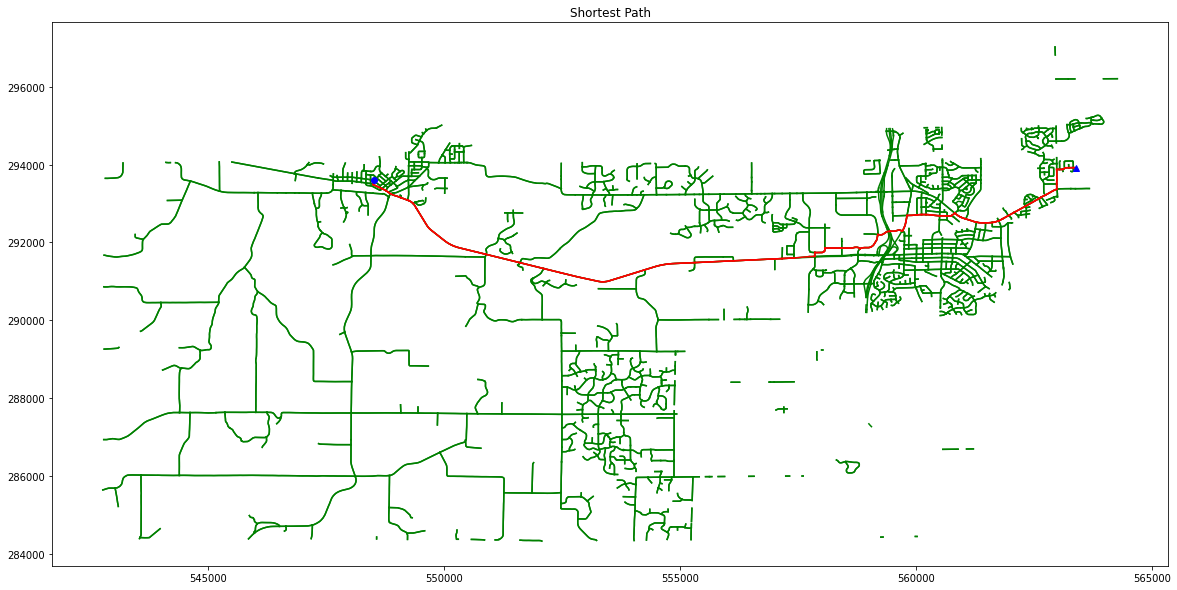

In [104]:
plt.rcParams["figure.figsize"] = (20,10)
chosen = []
chosen_safe = []
plt.figure()

#plot original map 
for sp in shape.shapeRecords():
    road_id = sp.record[43]
    
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    
    if road_id in chosen_road:
        chosen.append((x,y))
        
    if road_id in chosen_road_safe:
        chosen_safe.append((x,y))
    plt.plot(x,y,'g')
    

    
#plot shortest path
for subpath in chosen:
    plt.plot(subpath[0],subpath[1],'r')
    pass
for subpath in chosen_safe:
    #plt.plot(subpath[0],subpath[1],'m')  
    pass
    
plt.plot(reference_coordinate[origin][0], reference_coordinate[origin][1],'b^')
plt.plot(reference_coordinate[destination][0], reference_coordinate[destination][1],'bo')

plt.title('Shortest Path')

plt.show()

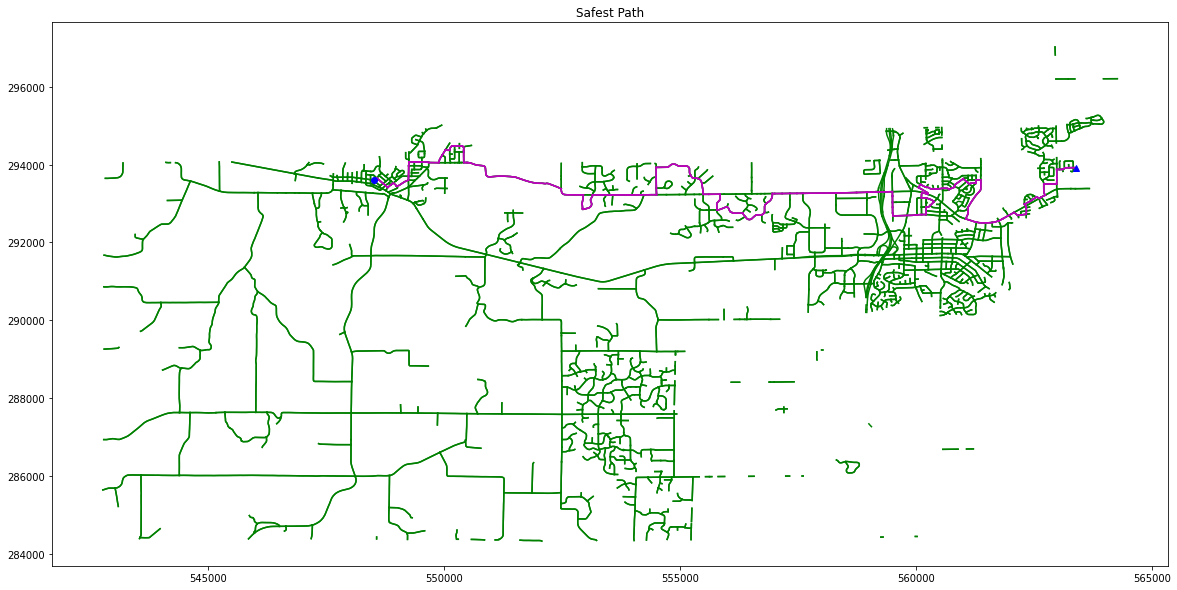

In [105]:
ju

In [106]:
## some nice points to look at
[('1661977', 1.0), ('1662164', -1.0)]
[57538.0]
[44.0]
[82697.0]
[15.0]

[('1661801', 1.0), ('1679421', -1.0)]
[40082.0]
[26.0]
[86756.0]
[2.0]

[('1663289', 1.0), ('2180701', -1.0)]
[38684.0]
[38.0]
[62687.0]
[24.0]

[24.0]